# Advanced HR Data Quality & Profiling Report

**Objective:** This notebook connects to the `aws_stage` database to perform an in-depth data quality analysis on the `raw__hr_kpi_t_sf_newsf_employees` table. It builds upon initial profiling by adding advanced, business-specific checks to identify logical inconsistencies in the HR data.

In [1]:
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

# Set plotting style and options
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
# --- Connection Details --- 
server = '172.22.74.254'
database = 'aws_stage'
username = 'extmertcan.coskun'
password = 'id3bGWpkLeDea4EAE4W9'
table_name = 'raw__hr_kpi_t_sf_newsf_employees'
schema_name = 'sf_odata' 

# Construct the connection string
conn_str = (
    f'DRIVER={{ODBC Driver 17 for SQL Server}};' 
    f'SERVER={server};' 
    f'DATABASE={database};' 
    f'UID={username};' 
    f'PWD={password};' 
    f'Encrypt=yes;' 
    f'TrustServerCertificate=yes;'
)

# Establish connection
try:
    cnxn = pyodbc.connect(conn_str)
    cursor = cnxn.cursor()
    print("Connection to database established successfully!")
except Exception as e:
    print(f"Failed to connect to the database. Error: {e}")

Connection to database established successfully!


In [3]:
query = f"SELECT * FROM [{schema_name}].[{table_name}]"

print("Loading full dataset from the database...")
df = pd.read_sql(query, cnxn)
print(f"Data loaded successfully with {len(df)} rows.")

# --- Data Preparation and Standardization ---
date_cols = ['start_date', 'job_start_date', 'job_end_date', 'end_date', 'date_of_birth', 
             'initial_hire_date', 'seniority_base_date', 'db_upload_timestamp']

print("\nStandardizing all date columns to timezone-naive...")
for col in date_cols:
    if col in df.columns:
        # Step 1: Convert column to datetime objects, forcing errors into NaT
        df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Step 2: If the column has timezone info (is aware), convert it to UTC
        if df[col].dt.tz is not None:
            df[col] = df[col].dt.tz_convert('UTC')
            
            # Step 3: IMPORTANT - Remove the timezone info, making it naive but standardized
            df[col] = df[col].dt.tz_localize(None)

print("Date standardization complete. All date columns are now timezone-naive.")
df.info()

Loading full dataset from the database...


C:\Users\mertc\AppData\Local\Temp\ipykernel_50032\1364919447.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, cnxn)


Data loaded successfully with 7829 rows.

Standardizing all date columns to timezone-naive...
Date standardization complete. All date columns are now timezone-naive.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7829 entries, 0 to 7828
Columns: 120 entries, seq_number to db_upload_timestamp
dtypes: datetime64[ns](9), float64(4), int64(1), object(106)
memory usage: 7.2+ MB


C:\Users\mertc\AppData\Local\Temp\ipykernel_50032\1364919447.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors='coerce')


In [24]:
# --- 5a. Missing Value Analysis ---
print("--- Missing Value Analysis ---")
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_df = pd.DataFrame({'column_name': df.columns, 'missing_percentage': missing_percentage})
missing_df = missing_df[missing_df['missing_percentage'] > 0].sort_values('missing_percentage', ascending=False)
print("Top 20 Columns with Missing Values (%):")
display(missing_df.head(20))
print('\n' + '='*80 + '\n')

# --- 5b. Date Field Range Analysis ---
print("--- Date Range Analysis ---")
date_summary = {col: {'Minimum Date': df[col].min(), 'Maximum Date': df[col].max()} for col in date_cols if col in df.columns}
summary_df = pd.DataFrame.from_dict(date_summary, orient='index')
display(summary_df)
print('\n' + '='*80 + '\n')

# --- 5c. Categorical Data Distribution ---
print("--- Categorical Value Distributions ---")
categorical_cols_to_analyze = ['employee_status_en', 'workplace_en', 'payroll_company', 'gender']
for col in categorical_cols_to_analyze:
    if col in df.columns:
        print(f"\n--- Value Counts for '{col}' ---")
        display(df[col].value_counts(dropna=False).to_frame().head(15))
print('\n' + '='*80 + '\n')

# --- 5d. Numeric Data Profiling ---
print("--- Descriptive Statistics for Numeric Columns ---")
numeric_df = df.select_dtypes(include=np.number)
if not numeric_df.empty:
    display(numeric_df.describe().T)
else:
    print("No numeric columns found.")
print('\n' + '='*80 + '\n')

--- Missing Value Analysis ---
Top 20 Columns with Missing Values (%):


,column_name,missing_percentage
end_date,end_date,99.808405
team_member_size,team_member_size,45.752970
total_team_size,total_team_size,45.752970
manager_user_id,manager_user_id,37.846468
job_level,job_level,0.012773




--- Date Range Analysis ---


,Minimum Date,Maximum Date
start_date,2004-07-13 00:00:00.000,2025-10-13 00:00:00.000
job_start_date,1996-06-10 00:00:00.000,2025-10-15 00:00:00.000
job_end_date,1753-01-01 00:00:00.000,2025-10-11 00:00:00.000
end_date,2025-10-13 00:00:00.000,2025-10-31 00:00:00.000
date_of_birth,1900-01-01 00:00:00.000,2025-07-01 00:00:00.000
initial_hire_date,1753-01-01 00:00:00.000,2025-10-15 00:00:00.000
seniority_base_date,1753-01-01 00:00:00.000,2025-10-15 00:00:00.000
db_upload_timestamp,2025-10-13 13:01:46.527,2025-10-13 13:01:46.527




--- Categorical Value Distributions ---

--- Value Counts for 'employee_status_en' ---


,count
employee_status_en,
Active,4248
Terminated,3575
Reported No Show,6



--- Value Counts for 'workplace_en' ---


,count
workplace_en,
VERİ AKTARIMI,2780
Site,2718
Central,1860
Corprate,470
None,1



--- Value Counts for 'payroll_company' ---


,count
payroll_company,
,2780
REC ULUSLARARASI,1804
RÖNESANS ENDÜSTRİ TESİS,584
RÖNESANS YÖNETİM A.Ş.,277
RÖNESANS HOLDİNG,234
RÖNESANS ÖZEL OKULLARI,215
RÖNESANS TÜRKMEN ŞUBE,196
RENAISSANCE INFRA CONSTRUCTION,164
RMI ULUSLARARASI İNŞ.TAAH.A.Ş,143



--- Value Counts for 'gender' ---


,count
gender,
M,5807
F,2021
,1




--- Descriptive Statistics for Numeric Columns ---


,count,mean,std,min,25%,50%,75%,max
seq_number,7829.0,1.178184e+00,5.184922e-01,1.000,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00
user_id,7829.0,4.977812e+07,1.170165e+07,253.000,4.706099e+07,4.706530e+07,4.706750e+07,9.876963e+07
manager_user_id,4866.0,4.858329e+07,9.717951e+06,253.000,4.703772e+07,4.705345e+07,4.706597e+07,9.875860e+07
total_team_size,4247.0,3.799388e+00,2.937787e+01,0.000,0.000000e+00,0.000000e+00,1.000000e+00,1.154000e+03
team_member_size,4247.0,9.891688e-01,2.591405e+00,0.000,0.000000e+00,0.000000e+00,1.000000e+00,4.600000e+01
job_level,7828.0,1.120312e+02,8.656717e+01,0.000,0.000000e+00,1.450000e+02,1.800000e+02,2.900000e+02
fte,7829.0,1.005306e+00,1.440103e-01,0.022,1.000000e+00,1.000000e+00,1.000000e+00,1.011100e+01
tenure_days,7829.0,8.168042e+01,1.850609e+02,0.000,4.200000e+01,1.030000e+02,1.030000e+02,7.762000e+03
tenure_years,7829.0,2.237820e-01,5.070162e-01,0.000,1.150685e-01,2.821918e-01,2.821918e-01,2.126575e+01


In [5]:
print("--- Logical Date Consistency Checks ---")

# Check 1: Job end date before job start date
invalid_end_dates = df[df['job_end_date'] < df['job_start_date']]
if not invalid_end_dates.empty:
    print(f"[ISSUE FOUND] {len(invalid_end_dates)} records where job_end_date is before job_start_date.")
    display(invalid_end_dates[['user_id', 'job_start_date', 'job_end_date']].head())
else:
    print("[OK] No records found where job_end_date is before job_start_date.")

# Check 2: Job start date before birth date
invalid_birth_dates = df[df['job_start_date'] < df['date_of_birth']]
if not invalid_birth_dates.empty:
    print(f"\n[ISSUE FOUND] {len(invalid_birth_dates)} records where job_start_date is before date_of_birth.")
    display(invalid_birth_dates[['user_id', 'date_of_birth', 'job_start_date']].head())
else:
    print("\n[OK] No records found where job_start_date is before date_of_birth.")
print('\n' + '='*80 + '\n')

--- Logical Date Consistency Checks ---
[ISSUE FOUND] 4254 records where job_end_date is before job_start_date.


,user_id,job_start_date,job_end_date
2767,47002014,2004-07-13,1753-01-01
2768,47002030,2005-09-03,1753-01-01
2769,47010665,2017-05-24,1753-01-01
2770,47015152,2013-09-02,1753-01-01
2771,47011278,2023-07-01,1753-01-01



[OK] No records found where job_start_date is before date_of_birth.




In [6]:
print("--- Employment Status Consistency Checks ---")

# The FIX: Create a timezone-NAIVE 'today' variable to match the standardized columns
today = pd.to_datetime(datetime.now().date())

# Check 1: Active employees with a past end date
# This comparison now works because both df['end_date'] and today are timezone-naive
active_with_past_end_date = df[(df['employee_status_en'] == 'Active') & (df['end_date'] < today)]
if not active_with_past_end_date.empty:
    print(f"[ISSUE FOUND] {len(active_with_past_end_date)} 'Active' employees have an end_date in the past.")
    display(active_with_past_end_date[['user_id', 'employee_status_en', 'end_date']].head())
else:
    print("[OK] No active employees found with a past end date.")

# Check 2: Terminated employees with no end date
terminated_no_end_date = df[(df['employee_status_en'] != 'Active') & (df['end_date'].isnull())]
if not terminated_no_end_date.empty:
    print(f"\n[ISSUE FOUND] {len(terminated_no_end_date)} non-Active employees are missing an end_date.")
    display(terminated_no_end_date[['user_id', 'employee_status_en', 'end_date']].head())
else:
    print("\n[OK] All non-Active employees have an end date.")
print('\n' + '='*80 + '\n')

--- Employment Status Consistency Checks ---
[OK] No active employees found with a past end date.

[ISSUE FOUND] 3575 non-Active employees are missing an end_date.


,user_id,employee_status_en,end_date
0,47045320,Terminated,NaT
1,47047553,Terminated,NaT
2,47050708,Terminated,NaT
3,47005344,Terminated,NaT
4,47008454,Terminated,NaT


In [7]:
print("--- ID and Hierarchy Integrity Checks ---")

# Check 1: Duplicate user_id entries
duplicate_users = df[df.duplicated(subset=['user_id'], keep=False)]
if not duplicate_users.empty:
    print(f"[ISSUE FOUND] {duplicate_users['user_id'].nunique()} user_ids have duplicate records.")
    display(duplicate_users[['user_id', 'name', 'surname', 'start_date']].sort_values('user_id').head())
else:
    print("[OK] All user_ids are unique.")

# Check 2: Employees who are their own manager
df['manager_user_id'] = pd.to_numeric(df['manager_user_id'], errors='coerce')
df['user_id'] = pd.to_numeric(df['user_id'], errors='coerce')
self_managed = df[df['user_id'] == df['manager_user_id']]
if not self_managed.empty:
    print(f"\n[ISSUE FOUND] {len(self_managed)} employees are listed as their own manager.")
    display(self_managed[['user_id', 'name', 'surname', 'manager_user_id']].head())
else:
    print("\n[OK] No employees are listed as their own manager.")
print('\n' + '='*80 + '\n')

--- ID and Hierarchy Integrity Checks ---
[OK] All user_ids are unique.

[OK] No employees are listed as their own manager.




--- Employee Tenure Analysis ---
[OK] No employees with negative tenure found.

Descriptive Statistics for Employee Tenure (in Years):


count    7829.000000
mean        0.223782
std         0.507016
min         0.000000
25%         0.115068
50%         0.282192
75%         0.282192
max        21.265753
Name: tenure_years, dtype: float64

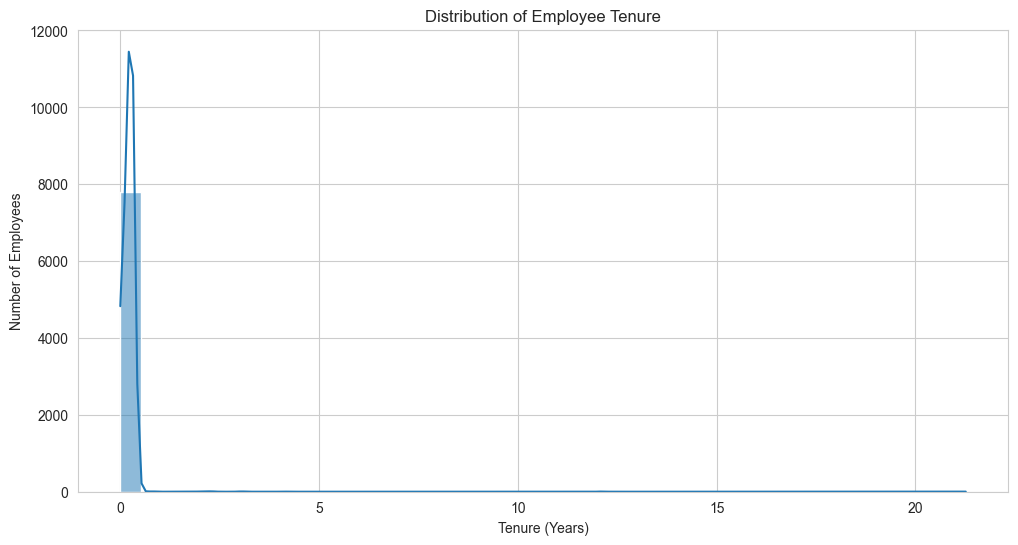

In [8]:
print("--- Employee Tenure Analysis ---")

# Calculate tenure in years. For active employees, use today as the end date.
end_date_for_tenure = df['end_date'].fillna(today)
df['tenure_days'] = (end_date_for_tenure - df['start_date']).dt.days
df['tenure_years'] = df['tenure_days'] / 365

# Check for negative tenure
negative_tenure = df[df['tenure_years'] < 0]
if not negative_tenure.empty:
    print(f"[ISSUE FOUND] {len(negative_tenure)} employees have negative tenure.")
    display(negative_tenure[['user_id', 'start_date', 'end_date', 'tenure_years']].head())
else:
    print("[OK] No employees with negative tenure found.")

# Display descriptive statistics for tenure
print("\nDescriptive Statistics for Employee Tenure (in Years):")
display(df['tenure_years'].describe())

# Visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['tenure_years'].dropna(), bins=40, kde=True)
plt.title('Distribution of Employee Tenure')
plt.xlabel('Tenure (Years)')
plt.ylabel('Number of Employees')
plt.show()

In [20]:
# Cell to add after the status consistency check
print("--- Deeper Dive: Who are the 'Active' employees with past end dates? ---")

# The FIX: Create a timezone-NAIVE timestamp for today to match the naive 'end_date' column.
today = pd.to_datetime('today').normalize()

# This comparison now works because both 'end_date' and 'today' are timezone-naive.
active_with_past_end_date = df[(df['employee_status_en'] == 'Active') & (df['end_date'] < today)]

if not active_with_past_end_date.empty:
    print(f"\n[ISSUE FOUND] {len(active_with_past_end_date)} 'Active' employees have a past end date.")
    
    print("\nBreakdown by Payroll Company:")
    display(active_with_past_end_date['payroll_company'].value_counts())
    
    print("\nBreakdown by Workplace:")
    display(active_with_past_end_date['workplace_en'].value_counts().head(10))
else:
    print("No 'Active' employees with past end dates to analyze.")

--- Deeper Dive: Who are the 'Active' employees with past end dates? ---
No 'Active' employees with past end dates to analyze.


In [16]:
# Cell to add after the numeric profiling
print("\n--- Identifying Managers with the Largest Teams ---")

# Sort by team size and show the top 10
largest_teams = df.sort_values('total_team_size', ascending=False).dropna(subset=['total_team_size'])

# Display relevant columns for the managers with the largest teams
display(largest_teams[['name', 'surname', 'position', 'total_team_size']].head(10))


--- Identifying Managers with the Largest Teams ---


,name,surname,position,total_team_size
7584,LEVENT,ÖZAYAZ,ENDÜSTRİ TESİSLERİ GRUP BAŞKANI,1154.0
7095,OSMAN,BOZKURT,İCRA KURULU BAŞKANI,658.0
2767,KAMİL,YANIKÖMEROĞLU,GAYRİMENKUL YATIRIM GRUP BAŞKANI,510.0
2952,RASİM MURAT,MANAV,ALTYAPI İŞLERİ BAŞKANI,486.0
5686,EYÜP FATİH,ARS,GENEL MÜDÜR,465.0
2768,İPEK,ILICAK KAYAALP,YÖNETİM KURULU BAŞKANI,389.0
6426,İBRAHİM MERT,BAŞARAN,İCRA KURULU ÜYESİ,336.0
3105,YALIM,GÜRAKAN,GENEL MÜDÜR,253.0
3251,FATİH,ULUBAY,GENEL MÜDÜR YARDIMCISI,244.0
6466,CEM,OZOGUZ,PROGRAM GENEL MÜDÜRÜ,232.0



--- Average Tenure by Payroll Company ---
Average Tenure (Years):


payroll_company
RÖNESANS SAĞLIK                             1.365753
CYN PETROKİMYA END. VE TİC. AŞ              1.054047
TEPEBEY MADENCİLİK İNŞAAT YAT.              0.567671
RSC RÖNESANS SATIN ALMA                     0.350931
RÖNESANS ÖZEL OKULLARI                      0.349678
RÖNESANS HOLDİNG                            0.306147
CEYHAN PETROKMYA END.YÖN.                   0.305479
RÖNESANS INFRA ALTYAPI                      0.294934
SİBELRES ELEKTRİK A.Ş.                      0.284932
RÖNESANS ŞARJ İSTASYON ENERJİ YATA A.Ş.     0.284932
AVKAL ENERJİ A.Ş.                           0.284932
BİR ADIM VAR VAKFI                          0.284932
DESNA HOLDİNG A.Ş.                          0.284932
RÖNESANS REY ENDÜSTRİYEL YATIRIMLARI A.Ş    0.284932
                                            0.282639
Name: tenure_years, dtype: float64

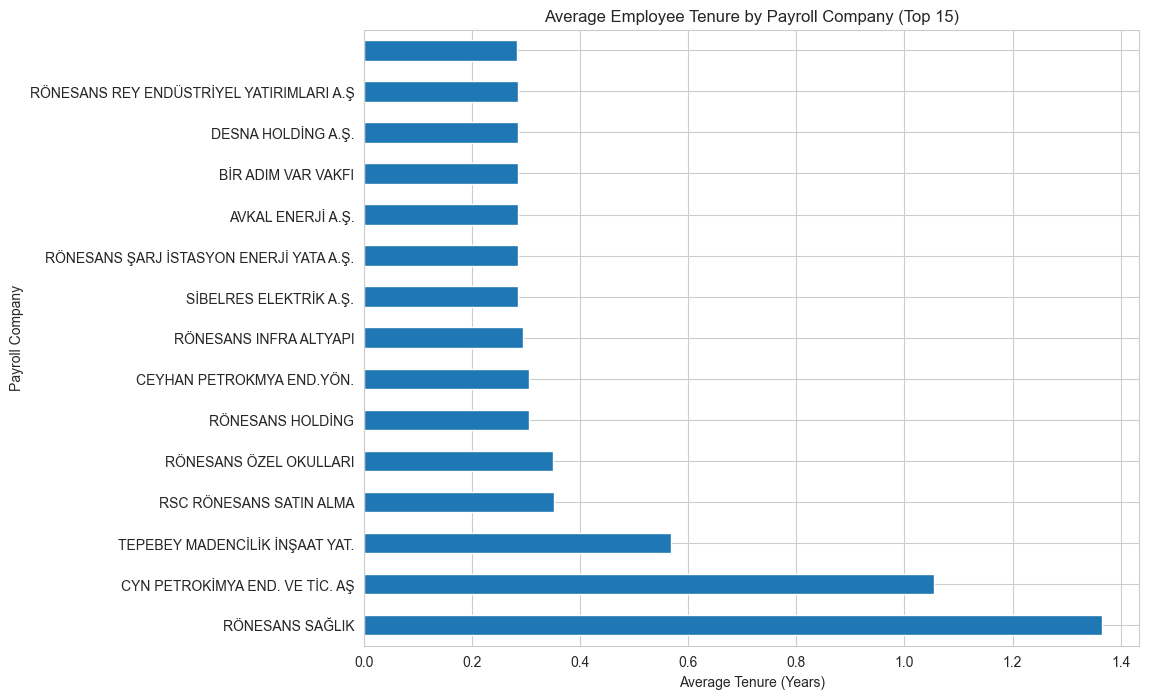

In [18]:
# Cell to add at the end of the Tenure Analysis
print("\n--- Average Tenure by Payroll Company ---")

# Calculate the average tenure in years for each payroll company
tenure_by_company = df.groupby('payroll_company')['tenure_years'].mean().sort_values(ascending=False)

print("Average Tenure (Years):")
display(tenure_by_company.head(15))

# Visualize this
plt.figure(figsize=(10, 8))
tenure_by_company.head(15).plot(kind='barh')
plt.title('Average Employee Tenure by Payroll Company (Top 15)')
plt.xlabel('Average Tenure (Years)')
plt.ylabel('Payroll Company')
plt.show()

# Visualizations for Outlier Detection

**Objective:** This section focuses on creating visualizations to identify outliers in key numeric and date-based columns. Outliers can represent data entry errors, special cases, or important trends that require further investigation.

In [25]:
if 'date_of_birth' in df.columns:
    today = pd.to_datetime('today').normalize()
    df['age'] = (today - df['date_of_birth']).dt.days / 365.25
    print("Successfully calculated 'age' column.")
    display(df[['age']].describe().T)
else:
    print("Column 'date_of_birth' not found, skipping age calculation.")

Successfully calculated 'age' column.


,count,mean,std,min,25%,50%,75%,max
age,7829.0,35.325827,9.450415,0.284736,27.550992,34.45859,41.431896,125.779603


--- Identifying Outliers with Box Plots ---


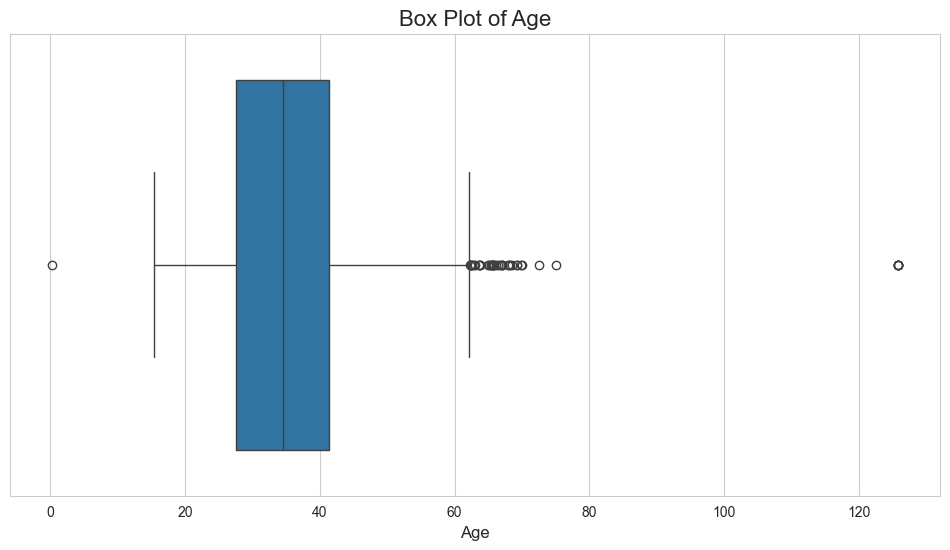

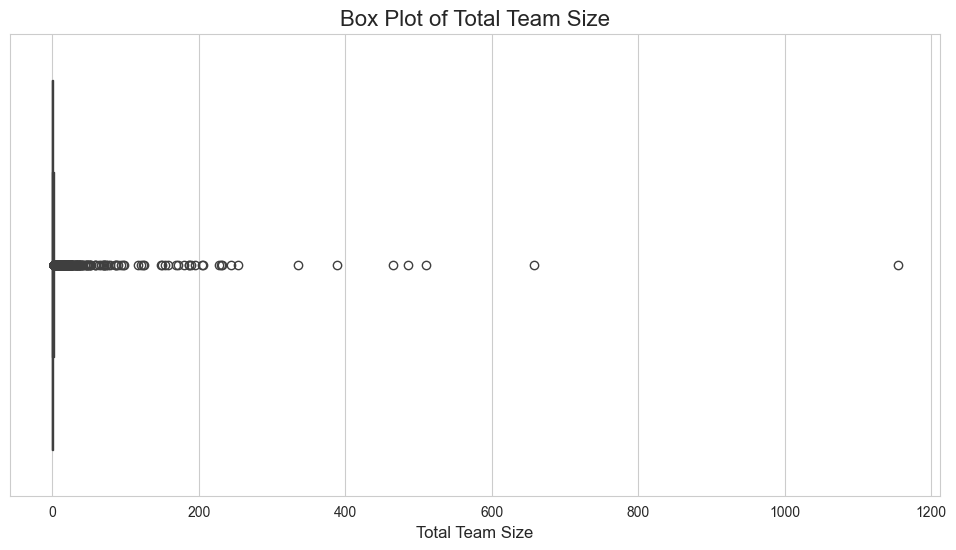

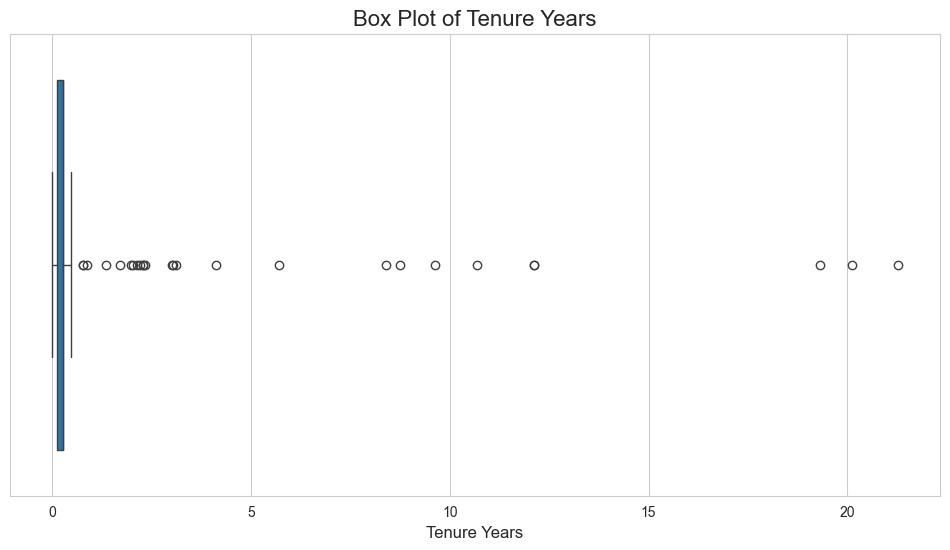

In [26]:
numeric_cols_for_outliers = ['age', 'total_team_size', 'tenure_years']

print("--- Identifying Outliers with Box Plots ---")
for col in numeric_cols_for_outliers:
    if col in df.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Box Plot of {col.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(col.replace("_", " ").title(), fontsize=12)
        plt.show()
    else:
        print(f"Column '{col}' not found in DataFrame.")


--- Understanding Data Distribution with Histograms ---


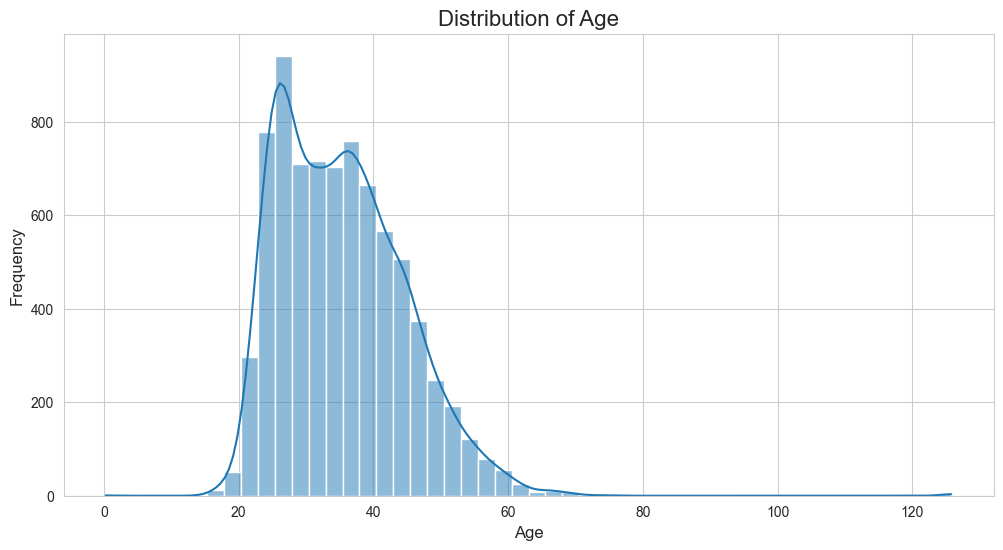

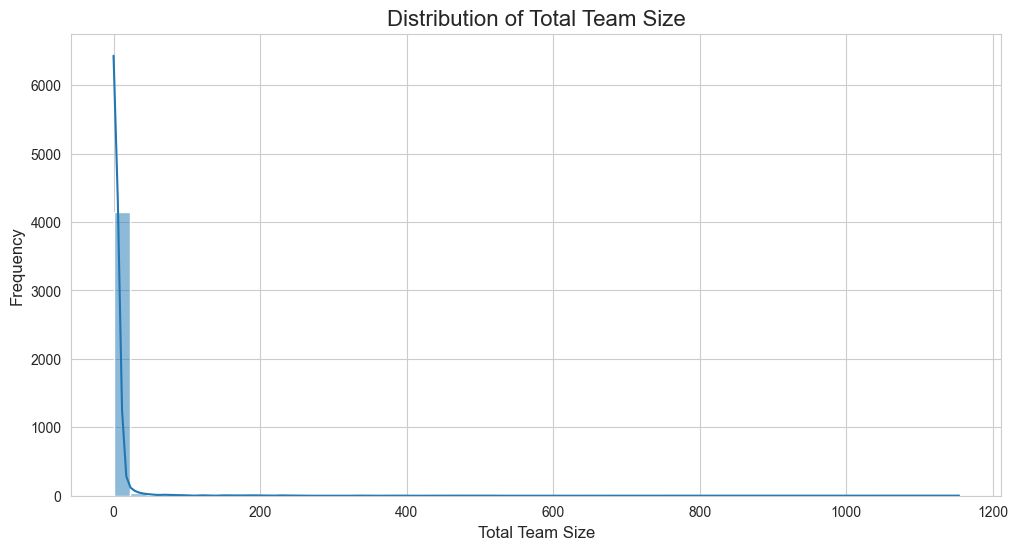

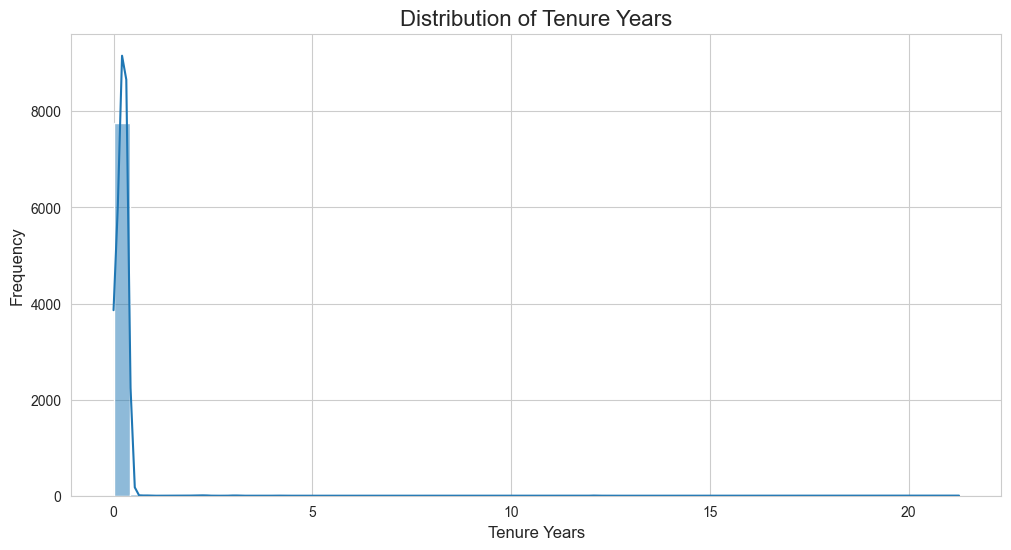

In [27]:
print("\n--- Understanding Data Distribution with Histograms ---")
for col in numeric_cols_for_outliers:
    if col in df.columns:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col].dropna(), kde=True, bins=50)
        plt.title(f'Distribution of {col.replace("_", " ").title()}', fontsize=16)
        plt.xlabel(col.replace("_", " ").title(), fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.show()
    else:
        print(f"Column '{col}' not found in DataFrame.")

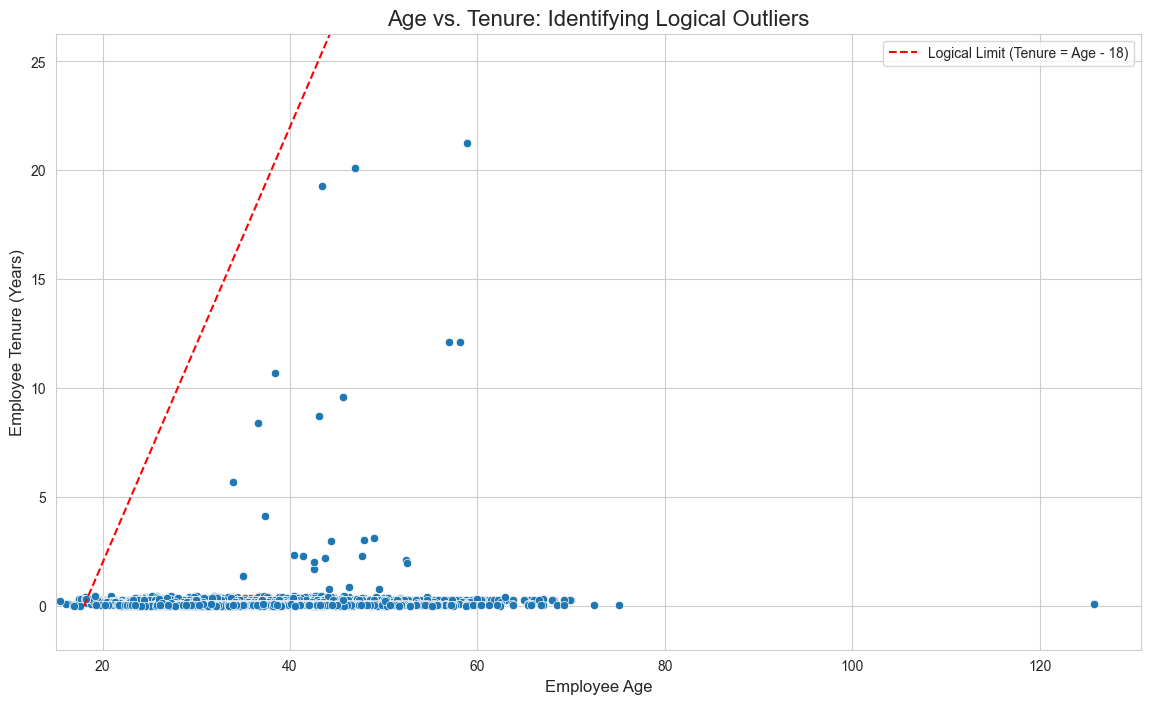

In [28]:
if 'age' in df.columns and 'tenure_years' in df.columns:
    plt.figure(figsize=(14, 8))
    sns.scatterplot(x='age', y='tenure_years', data=df)
    
    # Add a logical boundary line: tenure cannot be more than age - 18
    plt.plot([18, 80], [0, 62], color='red', linestyle='--', label='Logical Limit (Tenure = Age - 18)')
    
    plt.title('Age vs. Tenure: Identifying Logical Outliers', fontsize=16)
    plt.xlabel('Employee Age', fontsize=12)
    plt.ylabel('Employee Tenure (Years)', fontsize=12)
    plt.legend()
    plt.xlim(15, df['age'].max() + 5)
    plt.ylim(-2, df['tenure_years'].max() + 5)
    plt.show()
else:
    print("Required columns 'age' and/or 'tenure_years' not found.")

--- Visualizing Missing Data Patterns ---


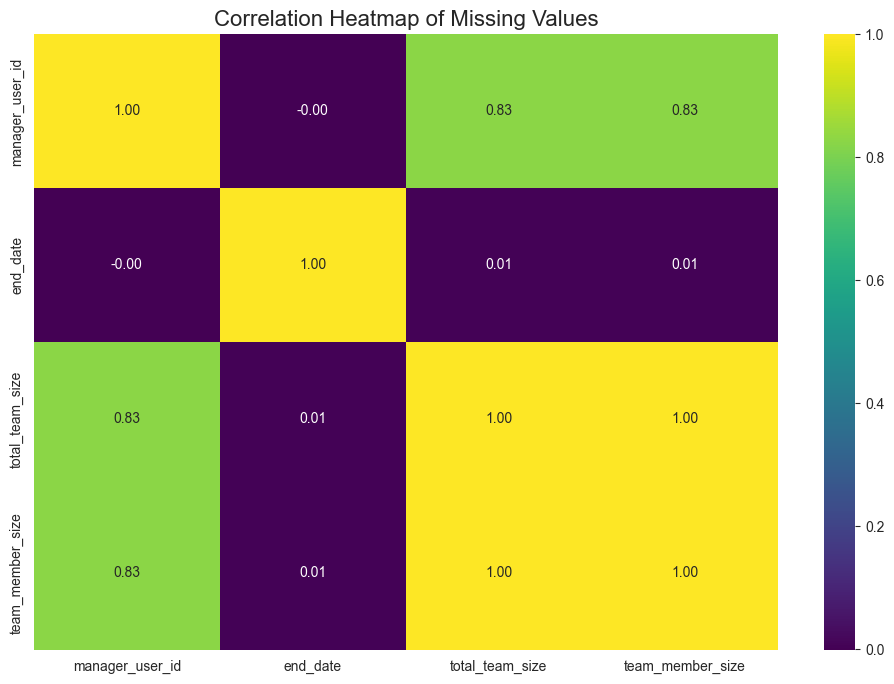


Interpretation: A high value (close to 1.0) between two columns means that when one is missing, the other is very likely to be missing too.


In [29]:
print("--- Visualizing Missing Data Patterns ---")

# Select columns with a significant percentage of missing values to keep the heatmap readable
missing_percentage = df.isnull().sum() / len(df)
cols_with_high_missing = missing_percentage[missing_percentage > 0.2].index

if not cols_with_high_missing.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(df[cols_with_high_missing].isnull().corr(), annot=True, cmap='viridis', fmt='.2f')
    plt.title('Correlation Heatmap of Missing Values', fontsize=16)
    plt.show()
    print("\nInterpretation: A high value (close to 1.0) between two columns means that when one is missing, the other is very likely to be missing too.")
else:
    print("No columns with more than 20% missing data to correlate.")

In [30]:
print("\n--- Breakdown of 'Active' Employees with Past End Dates ---")

# Re-create the filter for the inconsistent records
today = pd.to_datetime('today').normalize()
active_with_past_end_date = df[(df['employee_status_en'] == 'Active') & (df['end_date'] < today)]

if not active_with_past_end_date.empty:
    plt.figure(figsize=(12, 8))
    
    # Get the top 15 companies with this issue
    company_counts = active_with_past_end_date['payroll_company'].value_counts().nlargest(15)
    
    sns.barplot(x=company_counts.values, y=company_counts.index, palette='Reds_r')
    
    plt.title('Top 15 Payroll Companies with "Active" Employees Having Past End Dates', fontsize=16)
    plt.xlabel('Number of Inconsistent Records', fontsize=12)
    plt.ylabel('Payroll Company', fontsize=12)
    plt.show()
else:
    print("No 'Active' employees with past end dates to analyze.")


--- Breakdown of 'Active' Employees with Past End Dates ---
No 'Active' employees with past end dates to analyze.



--- Employee Tenure Distribution by Payroll Company ---


C:\Users\mertc\AppData\Local\Temp\ipykernel_50032\3480729854.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


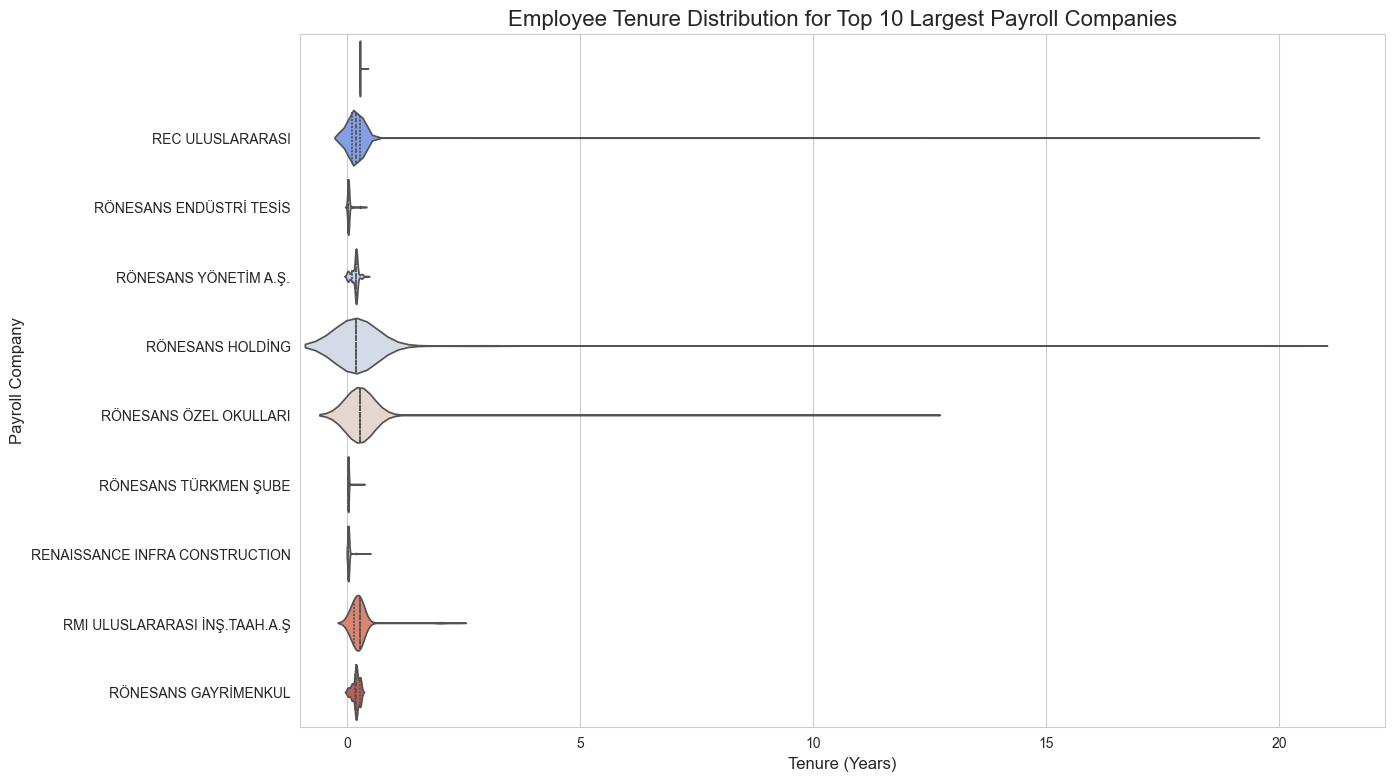

In [31]:
print("\n--- Employee Tenure Distribution by Payroll Company ---")

# Get the top 10 largest companies by employee count for a cleaner plot
top_10_companies = df['payroll_company'].value_counts().nlargest(10).index
df_top_10 = df[df['payroll_company'].isin(top_10_companies)]

plt.figure(figsize=(14, 9))
sns.violinplot(
    x='tenure_years', 
    y='payroll_company', 
    data=df_top_10, 
    order=top_10_companies,
    palette='coolwarm',
    inner='quartile' # Shows the median and quartiles inside the violin
)
plt.title('Employee Tenure Distribution for Top 10 Largest Payroll Companies', fontsize=16)
plt.xlabel('Tenure (Years)', fontsize=12)
plt.ylabel('Payroll Company', fontsize=12)
plt.xlim(-1, df['tenure_years'].max() + 1) # Set x-limit to handle potential outliers
plt.show()


--- Data Completeness of 'total_team_size' by Hire Year ---


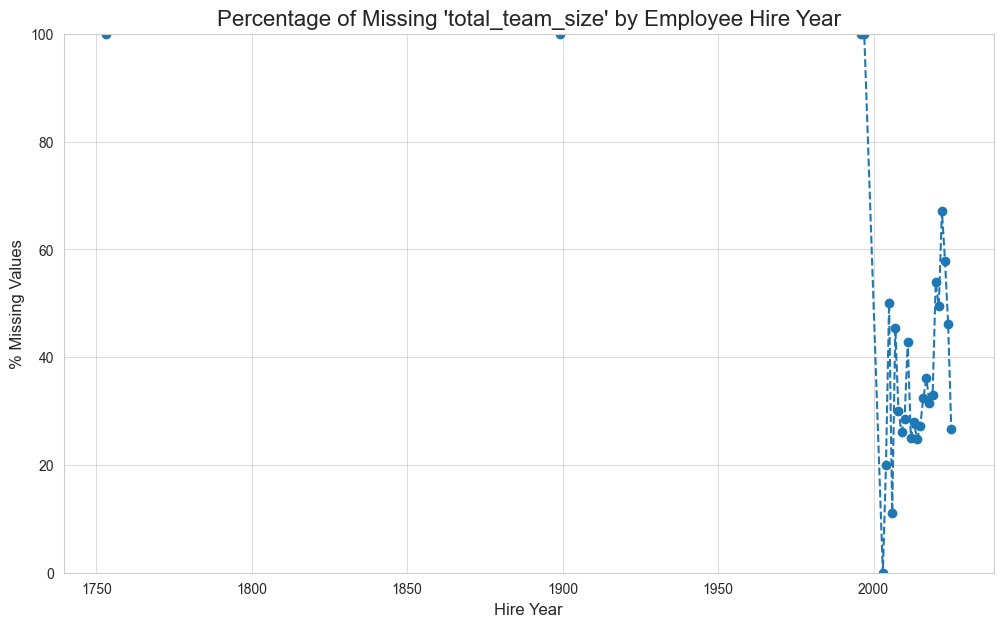

In [32]:
print("\n--- Data Completeness of 'total_team_size' by Hire Year ---")

# Make sure initial_hire_date is a datetime object
df['hire_year'] = df['initial_hire_date'].dt.year

# Calculate the percentage of missing 'total_team_size' for each year
completeness_over_time = df.groupby('hire_year')['total_team_size'].apply(lambda x: x.isnull().mean() * 100)
completeness_over_time = completeness_over_time.dropna().sort_index()

if not completeness_over_time.empty:
    plt.figure(figsize=(12, 7))
    completeness_over_time.plot(kind='line', marker='o', linestyle='--')
    plt.title("Percentage of Missing 'total_team_size' by Employee Hire Year", fontsize=16)
    plt.ylabel('% Missing Values', fontsize=12)
    plt.xlabel('Hire Year', fontsize=12)
    plt.ylim(0, 100)
    plt.grid(True, which='both', linestyle='-', linewidth=0.5)
    plt.show()
else:
    print("Could not generate completeness over time plot. Check 'initial_hire_date' column.")

In [ ]:
try:
    cnxn.close()
    print("Database connection closed.")
except NameError:
    print("No active database connection to close.")

Database connection closed.
